# Categorical EDA (Karim) - простой рабочий ноутбук

Запускай ячейки сверху вниз. Если ловишь редкую ошибку `pandas.period already defined`,
перезапусти Kernel и снова Run All.


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from pyarrow.lib import ArrowKeyError
import pyarrow as pa

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, kruskal
from sklearn.feature_selection import mutual_info_classif

sns.set_theme(style='whitegrid')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


In [2]:
REPO_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_DIR = os.path.join(REPO_ROOT, 'src' , 'data')
OUT_DIR = os.path.join(REPO_ROOT, 'outputs', 'categorical_analysis')

LABELS_PATH = os.path.join(DATA_DIR, 'train_labels.parquet')

PRETRAIN_FILES = [
    os.path.join(DATA_DIR,'pretrain_part_1.parquet'),
    os.path.join(DATA_DIR,'pretrain_part_2.parquet'),
    os.path.join(DATA_DIR,'pretrain_part_3.parquet'),
]
TRAIN_FILES = [
    os.path.join(DATA_DIR,'train_part_1.parquet'),
    os.path.join(DATA_DIR,'train_part_2.parquet'),
    os.path.join(DATA_DIR,'train_part_3.parquet'),
]


print(f'Project root: {REPO_ROOT}')
print('LABELS_PATH:', LABELS_PATH)
print('TRAIN FILES:')
for x in TRAIN_FILES:
    print('\t-', x)
print('PRETRAIN FILES:')
for x in PRETRAIN_FILES:
    print('\t-', x)


Project root: /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest
LABELS_PATH: /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_labels.parquet
TRAIN FILES:
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_part_1.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_part_2.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_part_3.parquet
PRETRAIN FILES:
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/pretrain_part_1.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/pretrain_part_2.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/pretrain_part_3.parquet


# Read Train Labels

In [3]:
labels = pd.read_parquet(LABELS_PATH)
labels.head(10)

,customer_id,event_id,target
0,123123123123129,124093788813382,0
1,123123123123138,126035112904381,0
2,123123123123169,124325714018852,1
3,123123123123169,124944191029616,1
4,123123123123169,126395888234936,1
5,123123123123212,125932035614428,1
6,123123123123244,126000752300936,0
7,123123123123244,126413069904279,0
8,123123123123252,123131714049918,1
9,123123123123252,124875471589677,1


In [4]:
labels.info(), len(labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87514 entries, 0 to 87513
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  87514 non-null  int64
 1   event_id     87514 non-null  int64
 2   target       87514 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 1.7 MB


(None, 87514)

# Reading Train 1

In [5]:
train_df_1 = pd.read_parquet(TRAIN_FILES[0])
train_df_1.head(10)

,customer_id,event_id,event_dttm,event_type_nm,event_desc,channel_indicator_type,channel_indicator_sub_type,operaton_amt,currency_iso_cd,mcc_code,pos_cd,accept_language,browser_language,timezone,session_id,operating_system_type,battery,device_system_version,screen_size,developer_tools,phone_voip_call_state,web_rdp_connection,compromised
0,123123123123129,123999300382879,2024-10-01 05:29:14,14,75,6,5,56422.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
1,123123123123129,124531875713936,2024-10-01 10:17:22,7,56,4,15,NaN,NaN,None,NaN,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
2,123123123123129,123329285580171,2024-10-01 10:20:03,3,120,6,5,300870.0,0.0,10,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
3,123123123123129,124334305430665,2024-10-02 07:48:09,14,75,6,5,298458.0,0.0,1,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
4,123123123123129,126215501146513,2024-10-02 11:20:40,14,75,6,5,59944.0,0.0,15,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
5,123123123123129,126464610203810,2024-10-02 17:22:44,14,75,6,5,137235.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
6,123123123123129,125502539036271,2024-10-03 18:24:36,14,75,6,5,107159.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
7,123123123123129,123904810425848,2024-10-04 18:21:22,14,75,6,5,29388.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
8,123123123123129,126198323368888,2024-10-07 12:33:21,14,75,0,5,89946.0,0.0,15,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
9,123123123123129,123269153919321,2024-10-07 18:32:20,14,75,0,5,218215.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None


In [6]:
for c in train_df_1.columns:
    print(c, train_df_1[c].dtype, train_df_1[c].nunique(dropna=False))

customer_id int64 33333
event_id int64 28618594
event_dttm object 13374722
event_type_nm int32 17
event_desc int32 143
channel_indicator_type int32 7
channel_indicator_sub_type int32 16
operaton_amt float64 1094899
currency_iso_cd float64 20
mcc_code object 21
pos_cd float64 23
accept_language object 375
browser_language object 22
timezone float64 104
session_id float64 11823077
operating_system_type float64 12
battery object 118
device_system_version object 117
screen_size object 1523
developer_tools object 3
phone_voip_call_state float64 3
web_rdp_connection float64 3
compromised object 3


In [7]:
CATEGORICAL_COLUMNS = [
    'customer_id', 'event_id', 'session_id', # <---- Common feature Нельзя удалять тк обращаемся по ним!
    'pos_cd',
    'accept_language',
    'browser_language',
    'operating_system_type',
    'developer_tools',
    'phone_voip_call_state',
    'web_rdp_connection',
    'compromised',
    'timezone'
]
for col in CATEGORICAL_COLUMNS:
    print(f'{col}: {col in list(train_df_1.columns)}')
train_df_1 = train_df_1[CATEGORICAL_COLUMNS]
train_df_1.head()

customer_id: True
event_id: True
session_id: True
pos_cd: True
accept_language: True
browser_language: True
operating_system_type: True
developer_tools: True
phone_voip_call_state: True
web_rdp_connection: True
compromised: True
timezone: True


,customer_id,event_id,session_id,pos_cd,accept_language,browser_language,operating_system_type,developer_tools,phone_voip_call_state,web_rdp_connection,compromised,timezone
0,123123123123129,123999300382879,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN
1,123123123123129,124531875713936,NaN,NaN,None,None,NaN,None,NaN,NaN,None,NaN
2,123123123123129,123329285580171,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN
3,123123123123129,124334305430665,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN
4,123123123123129,126215501146513,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN


In [8]:
stats_df = pd.DataFrame({
    'missing_count': train_df_1.isna().sum(),
    'missing_rate': train_df_1.isna().sum() / len(train_df_1),
    'remaining_data': len(train_df_1) - train_df_1.isna().sum()
})
stats_df

,missing_count,missing_rate,remaining_data
customer_id,0,0.000000,28618594
event_id,0,0.000000,28618594
session_id,11400983,0.398377,17217611
pos_cd,26134680,0.913206,2483914
accept_language,25452822,0.889381,3165772
browser_language,25968210,0.907389,2650384
operating_system_type,25917436,0.905615,2701158
developer_tools,19888868,0.694963,8729726
phone_voip_call_state,22639583,0.791079,5979011
web_rdp_connection,24055569,0.840557,4563025


In [9]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28618594 entries, 0 to 28618593
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   customer_id            int64  
 1   event_id               int64  
 2   session_id             float64
 3   pos_cd                 float64
 4   accept_language        object 
 5   browser_language       object 
 6   operating_system_type  float64
 7   developer_tools        object 
 8   phone_voip_call_state  float64
 9   web_rdp_connection     float64
 10  compromised            object 
 11  timezone               float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.6+ GB


## Object Types

In [10]:
train_df_1['accept_language'].value_counts()

accept_language
ru                                                          2596882
ru-ru                                                        361905
ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7                          133580
ru,en;q=0.9                                                   16963
en-gb                                                         12210
                                                             ...   
en,ru;q=0.9,en-US;q=0.8,ru-RU;q=0.7,fi;q=0.6                      1
ru,en-US;q=0.9,en;q=0.8,sq;q=0.7                                  1
ru,en-US;q=0.9,en;q=0.8,fa;q=0.7                                  1
de-DE,de;q=0.9,ru-RU;q=0.8,ru;q=0.7,en-US;q=0.6,en;q=0.5          1
ru-RU,ru;q=0.9,fr-TN;q=0.8,fr;q=0.7,en-US;q=0.6,en;q=0.5          1
Name: count, Length: 374, dtype: int64

In [11]:
# def clean_accept_language(x) -> str:
#     if not x or x == '__MISSING__': return '__MISSING__'
#     if x[:2] in ['zh','*','ru', 'en']:return x[:2]
# 
# train_df_1['accept_language'] = train_df_1['accept_language'].apply(clean_accept_language)
# train_df_1['accept_language'].value_counts()

In [12]:
# def clean_browser_language(x) -> str:
#     if not x or x == '__MISSING__': return '__MISSING__'
#     return 'not available'
# train_df_1['browser_language'] = train_df_1['browser_language'].apply(clean_browser_language)
# train_df_1['browser_language'].value_counts()

In [13]:
train_df_1['developer_tools'] = train_df_1['developer_tools'].astype('Int64')
train_df_1['developer_tools'].value_counts()

developer_tools
0    7282484
1    1447242
Name: count, dtype: Int64

In [14]:
train_df_1['compromised'] = train_df_1['compromised'].astype('Int64')
train_df_1['compromised'].value_counts()

compromised
0    12927568
1       17587
Name: count, dtype: Int64

In [15]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28618594 entries, 0 to 28618593
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   customer_id            int64  
 1   event_id               int64  
 2   session_id             float64
 3   pos_cd                 float64
 4   accept_language        object 
 5   browser_language       object 
 6   operating_system_type  float64
 7   developer_tools        Int64  
 8   phone_voip_call_state  float64
 9   web_rdp_connection     float64
 10  compromised            Int64  
 11  timezone               float64
dtypes: Int64(2), float64(6), int64(2), object(2)
memory usage: 2.6+ GB


# Reading Train 2

In [16]:
# train_df_2 = pd.read_parquet(TRAIN_FILES[1])
# train_df_2 = train_df_2[CATEGORICAL_COLUMNS]
# train_df_2.head(10)

# Check Features

In [17]:
labels.head()

,customer_id,event_id,target
0,123123123123129,124093788813382,0
1,123123123123138,126035112904381,0
2,123123123123169,124325714018852,1
3,123123123123169,124944191029616,1
4,123123123123169,126395888234936,1


In [22]:
cat_cols = [
    'pos_cd','accept_language','browser_language','operating_system_type',
    'developer_tools','phone_voip_call_state','web_rdp_connection','compromised','timezone'
]

In [18]:
# CELL 1 — labels + merge (почему 87514 vs 28.6M)
# 87514 — это размеченные события (red/yellow),
# 28.6M — все события train.
# Для антифрода делаем бинарный target: 1 = red, 0 = все остальные (в т.ч. unlabeled).

df = train_df_1.merge(labels, on='event_id', how="left")
df["target_bin"] = (df["target"] == 1).astype("int8")  # red vs all

print("train rows:", len(train_df_1))
print("labels rows:", len(labels))
print("merged rows:", len(df))
print("positive rate:", df["target_bin"].mean().round(6))


train rows: 28618594
labels rows: 87514
merged rows: 28618594
positive rate: 0.000607


In [21]:
df.head()

,customer_id_x,event_id,session_id,pos_cd,accept_language,browser_language,operating_system_type,developer_tools,phone_voip_call_state,web_rdp_connection,compromised,timezone,customer_id_y,target,target_bin
0,123123123123129,123999300382879,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
1,123123123123129,124531875713936,NaN,NaN,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
2,123123123123129,123329285580171,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
3,123123123123129,124334305430665,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
4,123123123123129,126215501146513,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0


In [24]:
X = df[cat_cols].copy()
for c in cat_cols:
    X[c] = X[c].astype("string").fillna("__MISSING__").astype(str)

y = df['target_bin'].values


In [26]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import average_precision_score
split = int(len(df) * 0.8)
X_train, X_val = X.iloc[:split], X.iloc[split:]
y_train, y_val = y[:split], y[split:]

model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='PRAUC',
    iterations=1000,
    depth=8,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=100
)
model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_val, y_val), use_best_model=True)

pred = model.predict_proba(X_val)[:, 1]
print("AP:", average_precision_score(y_val, pred))

fi = pd.DataFrame({
    "feature": cat_cols,
    "importance": model.get_feature_importance(type="FeatureImportance")
}).sort_values("importance", ascending=False)
display(fi)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=0]=3.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

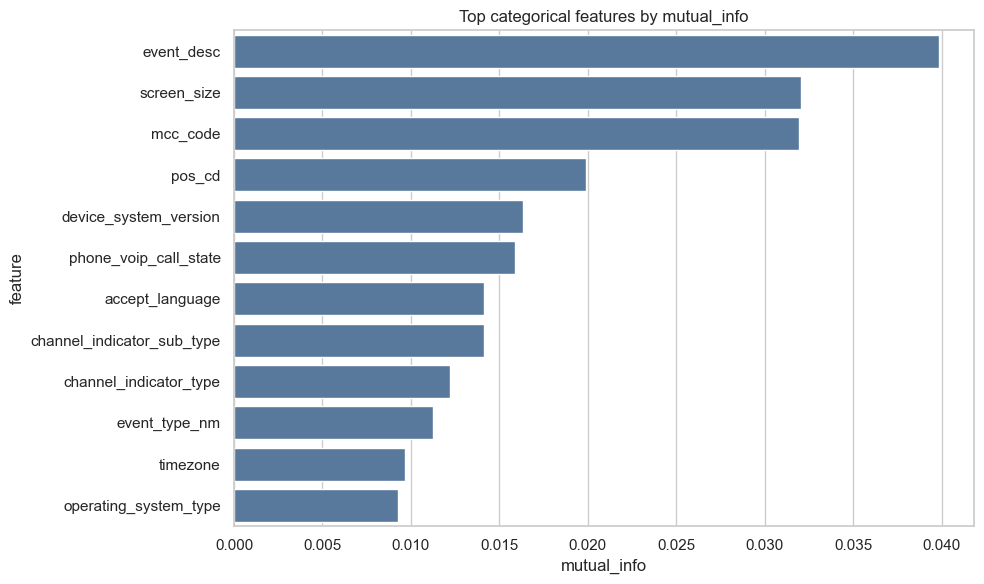

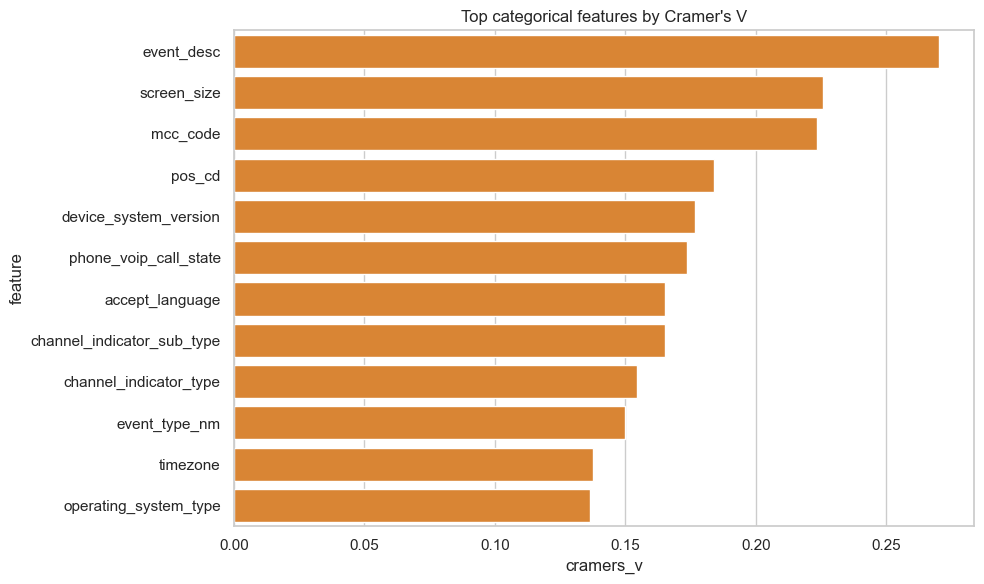

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics.head(12), y='feature', x='mutual_info', color='#4C78A8')
plt.title('Top categorical features by mutual_info')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics.sort_values('cramers_v', ascending=False).head(12), y='feature', x='cramers_v', color='#F58518')
plt.title("Top categorical features by Cramer's V")
plt.tight_layout()
plt.show()


In [42]:
def summarize_categorical(df, feature, min_count=30):
    cat = prep_cat(df[feature])
    tmp = pd.DataFrame({'cat': cat, 'target': df['target'].astype('int8')})
    summary = tmp.groupby('cat', dropna=False)['target'].agg(['count', 'mean', 'sum']).rename(
        columns={'mean': 'target_rate', 'sum': 'target_positives'}
    )
    summary = summary[summary['count'] >= min_count].sort_values('target_rate', ascending=False)
    return summary

TOP_FEATURES = metrics['feature'].head(5).tolist()
TOP_FEATURES


['event_desc', 'screen_size', 'mcc_code', 'pos_cd', 'device_system_version']

Feature: event_desc


,count,target_rate,target_positives
cat,,,
41,36,0.972222,35
73,2061,0.934498,1926
7,32,0.906250,29
103,47,0.893617,42
68,38,0.842105,32
29,459,0.830065,381
12,82,0.829268,68
31,1641,0.821450,1348
119,176,0.795455,140


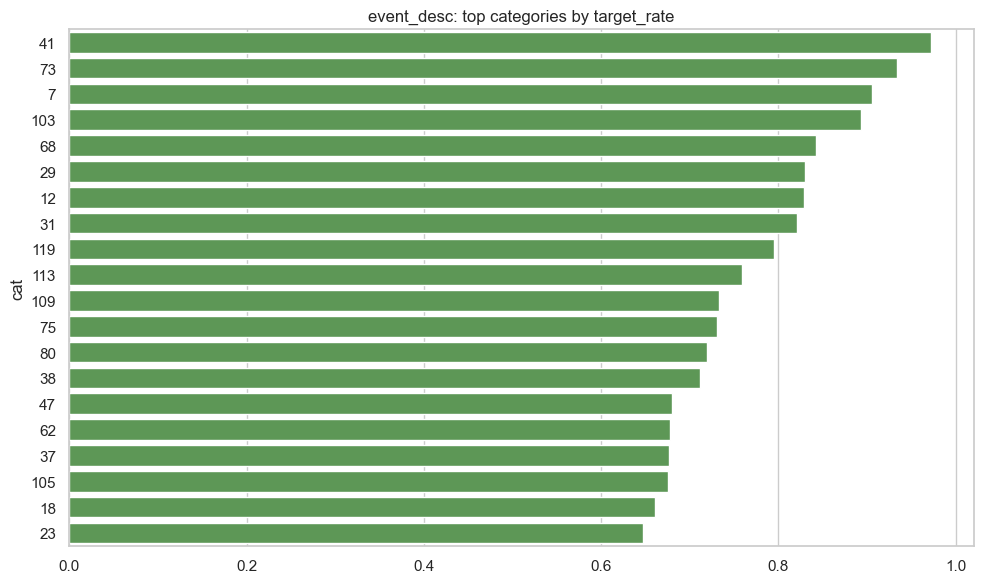

Feature: screen_size


,count,target_rate,target_positives
cat,,,
900x1600,56,0.982143,55
720x1451,40,0.925000,37
1080x2291,35,0.914286,32
720x1454,93,0.903226,84
720x1486,101,0.821782,83
720x1504,35,0.771429,27
720x1474,38,0.736842,28
720x1470,101,0.732673,74
1080x1920,247,0.724696,179


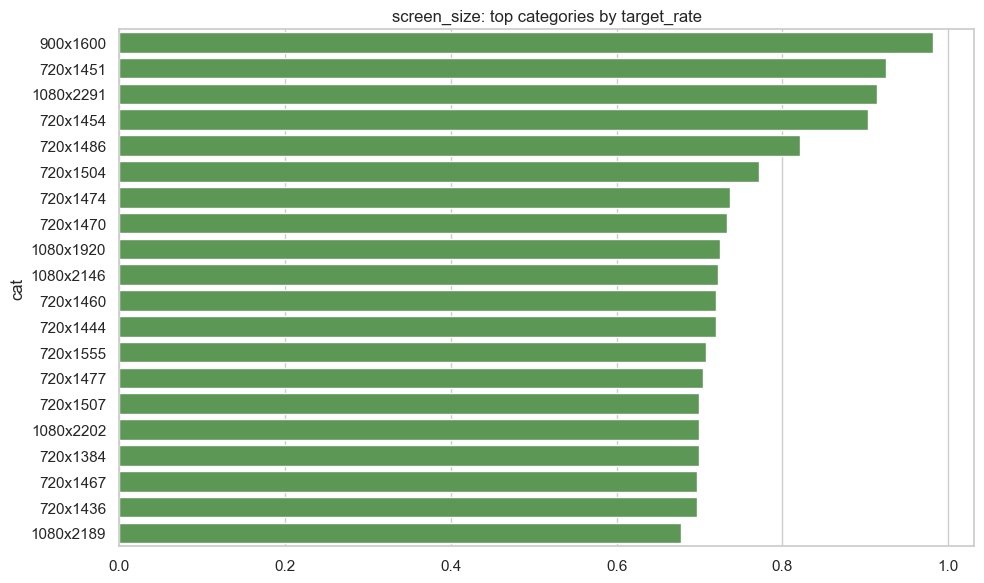

Feature: mcc_code


,count,target_rate,target_positives
cat,,,
16,3751,0.982938,3687
3,1001,0.956044,957
18,535,0.841121,450
19,1214,0.824547,1001
12,35,0.800000,28
13,127,0.748031,95
14,496,0.699597,347
10,8567,0.661959,5671
5,81,0.604938,49


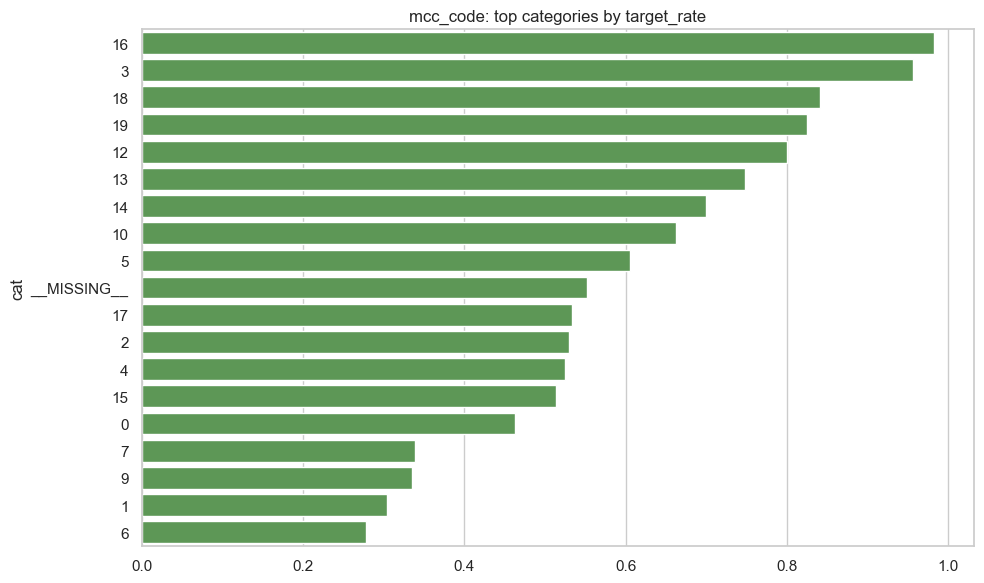

Feature: pos_cd


,count,target_rate,target_positives
cat,,,
4.0,58,0.982759,57
10.0,154,0.896104,138
1.0,6968,0.888921,6194
8.0,123,0.642276,79
__MISSING__,73495,0.561957,41301
3.0,6566,0.547213,3593
14.0,105,0.476190,50


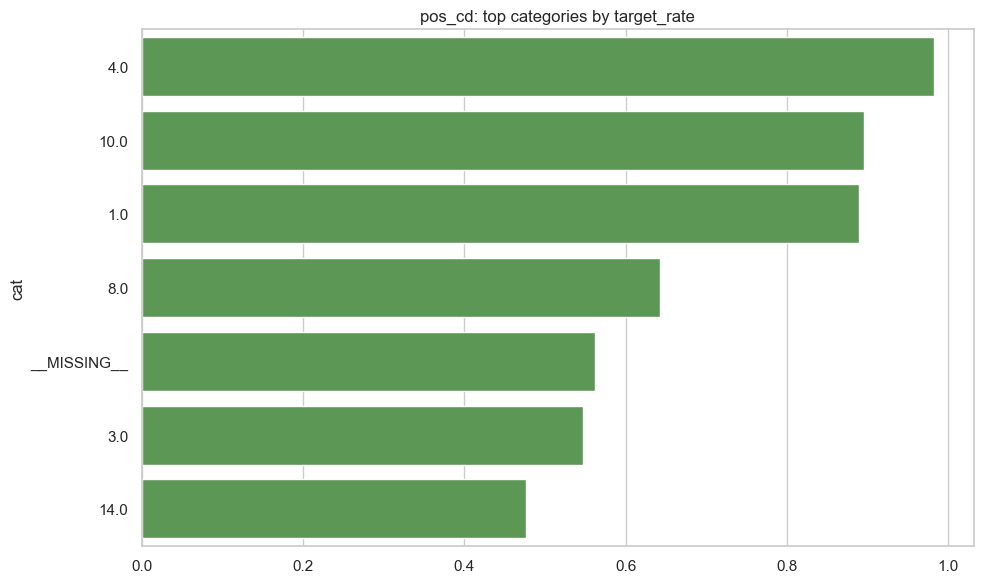

Feature: device_system_version


,count,target_rate,target_positives
cat,,,
__MISSING__,59237,0.638081,37798
8.1.0,166,0.572289,95
18.1,40,0.550000,22
9,792,0.540404,428
13,6026,0.536343,3232
11,2736,0.532895,1458
12,3587,0.524394,1881
10,2750,0.513818,1413
8.0.0,162,0.512346,83


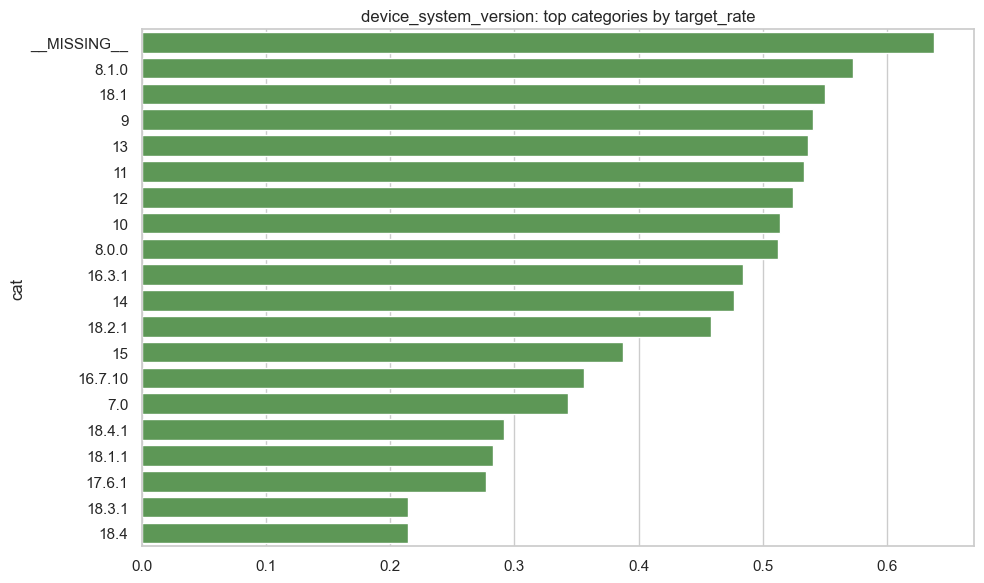

In [43]:
for feat in TOP_FEATURES:
    print('' + '=' * 90)
    print('Feature:', feat)
    summary = summarize_categorical(df, feat, min_count=30).head(20)
    display(summary)

    if not summary.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=summary['target_rate'].values, y=summary.index.astype(str), color='#54A24B')
        plt.title(f'{feat}: top categories by target_rate')
        plt.tight_layout()
        plt.show()


In [44]:
metrics.to_csv(OUT_DIR / 'categorical_feature_metrics.csv', index=False)

feature_summary_dir = OUT_DIR / 'feature_summaries'
feature_summary_dir.mkdir(parents=True, exist_ok=True)

for feat in AVAILABLE_CAT_COLS:
    s = summarize_categorical(df, feat, min_count=1)
    s.to_csv(feature_summary_dir / f'{feat}_summary.csv')

print('saved:', OUT_DIR / 'categorical_feature_metrics.csv')
print('saved dir:', feature_summary_dir)


saved: /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/outputs/categorical_analysis/categorical_feature_metrics.csv
saved dir: /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/outputs/categorical_analysis/feature_summaries
